In [1]:
######################################
########## GET data from DB ##########
######################################

import pandas as pd
from sqlalchemy import create_engine
from urllib import parse

# get connection information from .env file
with open('.env', 'r') as f:
  conn_info = dict(
    tuple(line.strip().split('='))
    for line in f
  )
# create engine for mysql
engine = create_engine((f"mysql://{conn_info['USER']}:{parse.quote(conn_info['PASSWORD'])}@{conn_info['HOST']}:{conn_info['PORT']}/{conn_info['DATABASE']}"))

In [2]:
sql = "SELECT * FROM final_data"
df = pd.read_sql(sql, engine)

display(df.shape)

(352543, 37)

In [25]:
# to pickle
# df.to_pickle('./seoul_real_estate/fin_data.pkl')

import pandas as pd
import numpy as np
import json
# read df from pickle
df = pd.read_pickle('./seoul_real_estate/fin_data.pkl')

In [26]:
# import libs for prediction modeling with tensorflow
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [27]:
# prepare data for modeling 

# get columns list
target_column = ['avg_sale_price']
columns = df.columns
display(columns)

# make derived features
#['gugun', 'dong', 'main_bunge', 'sub_bunge', 'road_name', 'road_num','danji_name', 'build_year', 'deal_month', 'size', 'avg_sale_price','avg_rent_deposit_price', 'hshld_cost', 'lo', 'la', 'elvtr_cnt','totprk_ecct', 'cctv_cnt', 'resident_population', 'net_migration','average_age', 'foreigner_population', 'stress_cognition_rate','subjective_health_level_cognition_rate', 'high_risk_drinking_rate','health_life_practice_rate', 'elementary_school_teachers','elementary_school_students', 'kindergarten_teachers','kindergarten_students', 'suicide_rate', 'building_age', 'elvtr_ratio','prk_ratio', 'cctv_ratio', 'foreigner_ratio', 'student_teacher_ratio']
# df['']


# columns to drop 
drop_columns = ['main_bunge', 'sub_bunge', 'danji_name', 'road_num', 'build_year', 'lo', 'la', 'elementary_school_teachers', 'elementary_school_students', 'kindergarten_teachers', 'kindergarten_students']
df.drop(drop_columns, axis=1, inplace=True)

# label encoding "gugun", "dong", "road_name" columns
import pickle
le_gugun = LabelEncoder()
df["gugun"] = le_gugun.fit_transform(df['gugun'])
encoding_table_gugun = dict(zip(le_gugun.classes_, le_gugun.transform(le_gugun.classes_)))
le_dong = LabelEncoder()
df["dong"] = le_dong.fit_transform(df['dong'])
encoding_table_dong = dict(zip(le_dong.classes_, le_dong.transform(le_dong.classes_)))
le_road = LabelEncoder()
df["road_name"] = le_road.fit_transform(df['road_name'])
encoding_table_road = dict(zip(le_road.classes_, le_road.transform(le_road.classes_)))

# save LabelEncoder object
with open('./seoul_real_estate/label_encoder.pkl', 'wb') as f:
  pickle.dump({'gugun': le_gugun, 'dong': le_dong, 'road_name': le_road}, f)
with open('./seoul_real_estate/encoding_table_gugun.json', 'w') as f:
  encoding_table_gugun = {str(key): int(value) for key, value in encoding_table_gugun.items()}
  json.dump(encoding_table_gugun, f)
with open('./seoul_real_estate/encoding_table_dong.json', 'w') as f:
  encoding_table_dong = {str(key): int(value) for key, value in encoding_table_dong.items()}
  json.dump(encoding_table_dong, f)
with open('./seoul_real_estate/encoding_table_road.json', 'w') as f:
  encoding_table_road = {str(key): int(value) for key, value in encoding_table_road.items()}
  json.dump(encoding_table_road, f)

# change object type to float average_age, suicide_rate
df['average_age'] = df['average_age'].replace({'-': np.nan})
df['average_age'] = df['average_age'].astype(float)
df['suicide_rate'] = df['suicide_rate'].replace({'-': np.nan})
df['suicide_rate'] = df['suicide_rate'].astype(float)
df['deal_month'] = (df['deal_month'] - pd.Timestamp("1970-01-01")) / pd.Timedelta('1s')

df = df.astype(float)

Index(['gugun', 'dong', 'main_bunge', 'sub_bunge', 'road_name', 'road_num',
       'danji_name', 'build_year', 'deal_month', 'size', 'avg_sale_price',
       'avg_rent_deposit_price', 'hshld_cost', 'lo', 'la', 'elvtr_cnt',
       'totprk_ecct', 'cctv_cnt', 'resident_population', 'net_migration',
       'average_age', 'foreigner_population', 'stress_cognition_rate',
       'subjective_health_level_cognition_rate', 'high_risk_drinking_rate',
       'health_life_practice_rate', 'elementary_school_teachers',
       'elementary_school_students', 'kindergarten_teachers',
       'kindergarten_students', 'suicide_rate', 'building_age', 'elvtr_ratio',
       'prk_ratio', 'cctv_ratio', 'foreigner_ratio', 'student_teacher_ratio'],
      dtype='object')

In [4]:
df.dropna(inplace=True)

In [5]:
# make dataset for modeling (train, test, validation)
Y = df[target_column]
X = df.drop(columns=target_column)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
# now we got train validation and test dataset for each X and Y


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 317245 entries, 2 to 352542
Data columns (total 26 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   gugun                                   317245 non-null  float64
 1   dong                                    317245 non-null  float64
 2   road_name                               317245 non-null  float64
 3   deal_month                              317245 non-null  float64
 4   size                                    317245 non-null  float64
 5   avg_sale_price                          317245 non-null  float64
 6   avg_rent_deposit_price                  317245 non-null  float64
 7   hshld_cost                              317245 non-null  float64
 8   elvtr_cnt                               317245 non-null  float64
 9   totprk_ecct                             317245 non-null  float64
 10  cctv_cnt                                317245 no

In [14]:
# build linear prediction model
model = tf.keras.Sequential([
  layers.Dense(64, activation='relu', input_shape=[X_train.shape[1]]),
  layers.Dense(64, activation='relu'),
  layers.Dense(1)
])

model.compile(
  optimizer='adam',
  loss='mse',
  metrics=['mae', 'mse']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                1664      
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,889
Trainable params: 5,889
Non-trainable params: 0
_________________________________________________________________


In [15]:
# train model
early_stop = keras.callbacks.EarlyStopping(monitor='val_mae', patience=10)
history = model.fit(
  X_train, Y_train,
  epochs=100,
  validation_data=(X_val, Y_val),
  callbacks=[early_stop],
  verbose=1
)

Epoch 1/100
6345/6345 [==============================] - 14s 2ms/step - loss: 2067672989696.0000 - mae: 430301.6250 - mse: 2067672989696.0000 - val_loss: 3092091502592.0000 - val_mae: 1755196.5000 - val_mse: 3092091502592.0000
Epoch 2/100
6345/6345 [==============================] - 17s 3ms/step - loss: 458171744256.0000 - mae: 474761.0625 - mse: 458171744256.0000 - val_loss: 280280432640.0000 - val_mae: 528073.0000 - val_mse: 280280432640.0000
Epoch 3/100
6345/6345 [==============================] - 14s 2ms/step - loss: 266032136192.0000 - mae: 348255.5938 - mse: 266032136192.0000 - val_loss: 129235214336.0000 - val_mae: 357870.5000 - val_mse: 129235214336.0000
Epoch 4/100
6345/6345 [==============================] - 16s 3ms/step - loss: 206076444672.0000 - mae: 242871.7188 - mse: 206076444672.0000 - val_loss: 8854669312.0000 - val_mae: 90098.2656 - val_mse: 8854669312.0000
Epoch 5/100
6345/6345 [==============================] - 16s 2ms/step - loss: 81681661952.0000 - mae: 209673.453

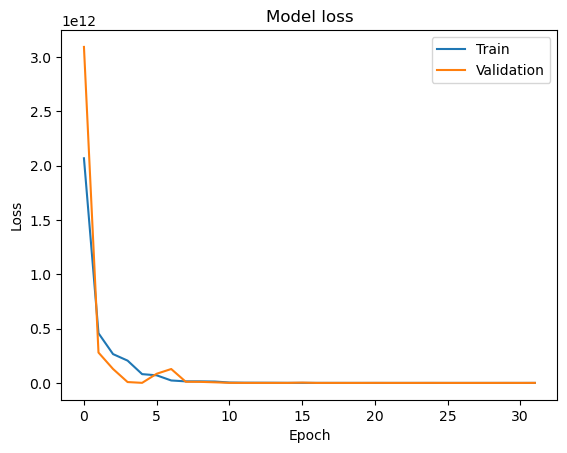

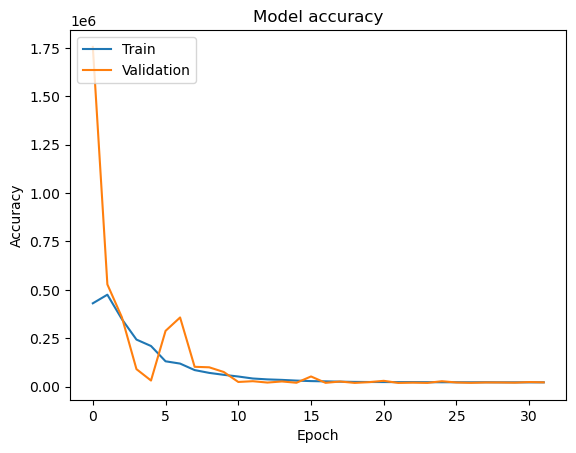

In [16]:
import matplotlib.pyplot as plt

# Plotting the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting the accuracy
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [17]:
# test model with x_text
predictions = model.predict(X_test)
# eval_result = model.evaluate(X_test, Y_test)

1983/1983 [==============================] - 3s 1ms/step


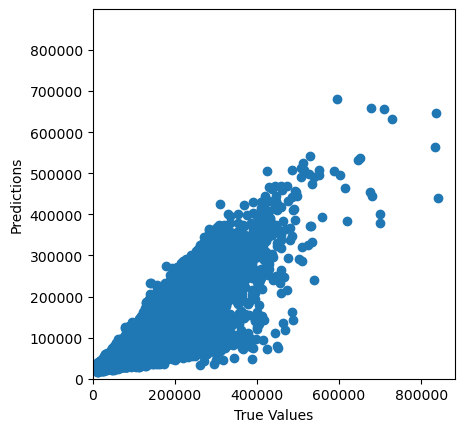

In [18]:
plt.scatter(Y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()

In [19]:
# save model
model.save('./seoul_real_estate/trained_model.h5')

In [20]:
display(predictions)

array([[54667.74 ],
       [50136.242],
       [51334.152],
       ...,
       [63393.438],
       [62916.598],
       [71133.53 ]], dtype=float32)